In [35]:
%load_ext autoreload
%autoreload 2
import logging
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from dnafiber.inference import _get_model
import math
import time
from dnafiber.postprocess.core import Fibers
import cv2
import pandas as pd
from dnafiber.postprocess.error_detection import load_model
from dnafiber.postprocess import refine_segmentation
from dnafiber.ui.inference import ui_inference_cacheless
from dnafiber.ui.utils import (
    get_image_cacheless,
)
from dnafiber.deployment import ENSEMBLE, Models

for name, l in logging.root.manager.loggerDict.items():
    if "streamlit" in name:
        l.disabled = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
reverse_channels = False
sint_file = Path("/home/clement/Documents/data/DNAFiber/Input/YM-2025-20/2025-05-16/siNT-01.czi")
sibrca1_file = Path("/home/clement/Documents/data/DNAFiber/Input/YM-2025-20/2025-05-16/siBRCA1-01.czi")

# model2  = _get_model("segformer_mit_b4_finetuned").cuda()
detection_model = None
# model = [model1, model2]
all_results_blurred = []
all_images_blurred = []

for file in tqdm([sint_file,  sibrca1_file], desc="Processing files"):
    image = get_image_cacheless(file, False)
   
    for sigma in np.linspace(0, 16, 5):
        ksize = int(2 * math.ceil(3 * sigma) + 1)
        gaussian_blurred = cv2.GaussianBlur(image, (ksize, ksize), sigma)
        all_images_blurred.append(gaussian_blurred)
        start = time.time()
        prediction: Fibers = ui_inference_cacheless(
            _model=ENSEMBLE,
            _image=gaussian_blurred,
            _device="cuda",
            use_tta=True,
            pixel_size=0.13,
            only_segmentation=False,
            use_correction=None,
        )
        df = prediction.to_df(img_name=file.stem, filter_invalid=False)
        df["Type"] = '-'.join(file.stem.split("-")[:-1])
        df["sigma"] = sigma
        all_results_blurred.append(df)


Processing files: 100%|██████████| 2/2 [03:43<00:00, 111.57s/it]


In [ ]:
from skimage.util import random_noise

all_results_noise = []
all_images_noise = []
for file in tqdm([sint_file, sibrca1_file], desc="Processing files"):
    image = get_image_cacheless(file, False)
    for sigma in np.linspace(0, 0.8, 5):
        noisy = random_noise(image, mode='gaussian', var=sigma**2, clip=True) * 255
        noisy = noisy.astype(np.uint8)
        all_images_noise.append(noisy)
        start = time.time()
        prediction: Fibers = ui_inference_cacheless(
            _model=ENSEMBLE,
            _image=noisy,
            _device="cuda",
            use_tta=True,
            pixel_size=0.13,
            only_segmentation=False,
            use_correction=None,
        )
        df = prediction.to_df(img_name=file.stem, filter_invalid=False)
        df["Type"] = '-'.join(file.stem.split("-")[:-1])
        df["sigma"] = sigma
        all_results_noise.append(df)



Processing files: 100%|██████████| 2/2 [04:27<00:00, 133.53s/it]


/tmp/ipykernel_484281/2441572460.py:29: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxenplot(
/tmp/ipykernel_484281/2441572460.py:29: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxenplot(
/tmp/ipykernel_484281/2441572460.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{sigma:.2f}" for sigma in df["sigma"].unique()])


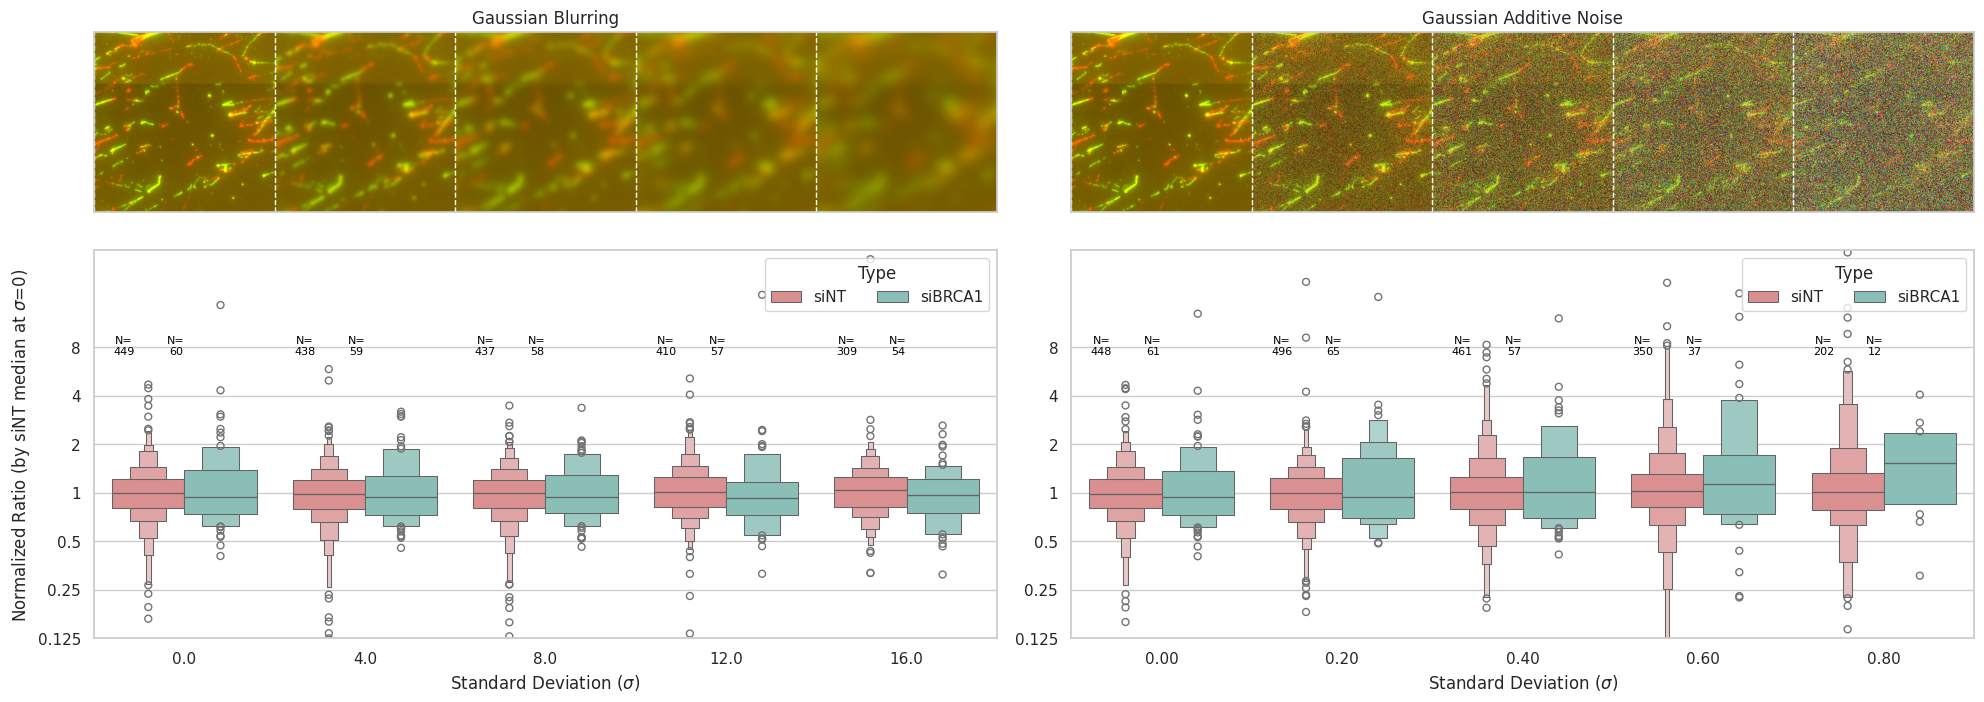

In [ ]:
from dnafiber.analysis.ratios import create_boxen_plot, normalize_df, graders_statistical_test, compare_pairs, create_swarm_plot, select_N_closest_to_mean

df_blurred = pd.concat(all_results_blurred, ignore_index=True)
df_blurred["sigma"] = df_blurred["sigma"].astype(str)
df_blurred["Ratio"] = df_blurred["Ratio"].astype(float)
df_noise = pd.concat(all_results_noise, ignore_index=True)
df_noise["sigma"] = df_noise["sigma"]
df_noise["Ratio"] = df_noise["Ratio"].astype(float)



order = ["siNT", "siBRCA1"]
df_blurred["Type"] = pd.Categorical(df_blurred["Type"], categories=order, ordered=True)
df_noise["Type"] = pd.Categorical(df_noise["Type"], categories=order, ordered=True)

df_noise = df_noise[df_noise["Valid"]]
df_blurred = df_blurred[df_blurred["Valid"]]

df_noise["Grader"] = "AI"
df_blurred["Grader"] = "AI"
normalize_df(df_blurred, "siNT")
normalize_df(df_noise, "siNT")
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(20, 8), sharey=False)

palette = ["#e78284", "#81c8be", "#8caaee"]
for i, (ax, df, title) in enumerate(zip(axes[1, :], [df_blurred, df_noise], ["Gaussian Blurring", "Gaussian Noise"])):
    sns.boxenplot(
        x="sigma",
        y="Ratio",
        hue="Type",
        data=df,
        ax=ax,
        palette=palette,
    )
    if i == 0:
        ax.set_ylabel(r"Normalized Ratio (by siNT median at $\sigma$=0)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel(r"Standard Deviation ($\sigma$)")
    ax.set_yscale("log")
    ax.set_yticks([0.125, 0.25, 0.5, 1, 2, 4, 8], 
                  [0.125, 0.25, 0.5, 1, 2, 4, 8])
    ax.set_ylim(0.125, 32)
    ax.minorticks_off()
    ax.legend(title="Type", loc="upper right", ncol=3)
    if title == "Gaussian Noise":
        ax.set_xticklabels([f"{sigma:.2f}" for sigma in df["sigma"].unique()])

    # Add text to indicate the number of fibers per sigma and type
    for i, sigma in enumerate(df["sigma"].unique()):
        for j, fiber_type in enumerate(df["Type"].unique()):
            count = df[(df["sigma"] == sigma) & (df["Type"] == fiber_type)].shape[0]
            ax.text(i+j/3.5 - 1/3, 7, f"N=\n{count}", ha='center', va='bottom', fontsize=8, color='black')

start = 4096
length = 512
subset_indices_y = slice(start, start + length)
subset_indices_x = slice(start, start + length)
for i, (ax, df, title) in enumerate(zip(axes[0, :], [df_blurred, df_noise], ["Gaussian Blurring", "Gaussian Additive Noise"])):
    sigmas = df["sigma"].unique()
    current_list = all_images_blurred if i == 0 else all_images_noise

    ax.set_ylim(0, 1)
    ax.set_xlim(0, len(sigmas))
    ax.set_yscale("linear")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

    for j, s in enumerate(sigmas):
        img1 = current_list[j][subset_indices_y, subset_indices_x]
        ax.imshow(img1, extent=[j, j+1, 0, 1])
        ax.axvline(j , color='white', linestyle='--', linewidth=1)
        
        
# Reduce the margin between the subplots
plt.subplots_adjust(hspace=0., wspace=0.2)
plt.tight_layout()
plt.savefig(f"noise_robustness_ensemble.png", dpi=300, bbox_inches='tight')
df_noise.to_csv("df_noise_ensemble.csv", index=False)
df_blurred.to_csv("df_blurred_ensemble.csv", index=False)
plt.show()



In [39]:
df_noise

,Fiber ID,First analog (µm),Second analog (µm),Ratio,Fiber type,Valid,Image Name,Type,sigma,Grader
1,1,5.72,19.50,2.482057,double,True,siNT-01,siNT,0.0,AI
3,3,12.74,21.45,1.225832,double,True,siNT-01,siNT,0.0,AI
4,4,10.14,16.12,1.157445,double,True,siNT-01,siNT,0.0,AI
8,8,27.30,21.19,0.565121,one-two-one,True,siNT-01,siNT,0.0,AI
9,9,9.88,32.63,2.404548,double,True,siNT-01,siNT,0.0,AI
...,...,...,...,...,...,...,...,...,...,...
4973,67,2.99,9.88,2.405797,double,True,siBRCA1-01,siBRCA1,0.8,AI
4974,68,4.81,14.95,2.262921,double,True,siBRCA1-01,siBRCA1,0.8,AI
4982,76,10.14,12.87,0.924089,double,True,siBRCA1-01,siBRCA1,0.8,AI
4983,77,6.37,14.04,1.604726,double,True,siBRCA1-01,siBRCA1,0.8,AI
